# Tutorial Day 1: Introduction to AI in medical imaging

In this interactive session you will learn more about XNAT, how XNAT stores data, and how you can access and downlonad imaging data from an XNAT server. During this session we will mostly work with the central XNAT server (https://xnat.bmia.nl), but we provide future references for more advanced usecases (e.g. uploading data ot the project you have access to).

XNAT offers REST API that allows its user to interact with an XNAT installation using scripts. Typically, you interact with a REST API by sending various HTTP requests: `GET` for getting data from the server, `POST` for sending any data to the server (including, for example, your login information), etc. However, this way of interaction is not optimal for research use cases. Because of that, we have built a Python wrapper for the XNAT REST API - xnatpy. If you would like to know more about how the library works you can open xnatpy [official documentation](https://xnat.readthedocs.io/en/latest/index.html).

Here is how it can help you in your research work:

In [1]:
# Necessary imports

import xnat
import os
import pydicom
import zipfile
import matplotlib.pyplot as plt
from skimage import filters

## Connecting to the XNAT server
First, we connect to the server by using the `connect` function from the `xnat` package:

In [2]:
session = xnat.connect('https://xnat.bmia.nl')

In general, `connect` function can take quite a few parameters (for example, your username), but since we are connecting to the public XNAT instance as a Guest account, we don't need to provide anything except for the server location. In order to terminate the session, use `session.disconnect()` function after you have finished your work.

## Exploring the XNAT server

As we mentioned in our supplementary material, XNAT has a hierarchical data model:
- Projects
- Subjects
- Sessions (a specific visit to a scanner)
- Scans (a specific type of scan during that visit)

For each of the levels of the hierarchy, a corresponding xnatpy class exists. Let's start by looking at all the projects from the server that we have connected to:

In [3]:
session.projects

<XNATListing {(ultra, ULTRA): <ProjectData ULTRA (ultra)>, (ultra_mumc, ULTRA_MUMC): <ProjectData ULTRA_MUMC (ultra_mumc)>, (NightlyTest, NightlyTest): <ProjectData NightlyTest (NightlyTest)>, (ultra_mch, ULTRA_MCH): <ProjectData ULTRA_MCH (ultra_mch)>, (ultra_lumc, ULTRA_LUMC): <ProjectData ULTRA_LUMC (ultra_lumc)>, (ultra_radboud, ULTRA_RADBOUD): <ProjectData ULTRA_RADBOUD (ultra_radboud)>, (bbmri-nl2, Demo Set): <ProjectData Demo Set (bbmri-nl2)>, (ultra_elisab, ULTRA_ELISAB): <ProjectData ULTRA_ELISAB (ultra_elisab)>, (ultra_umcu, ULTRA_UMCU): <ProjectData ULTRA_UMCU (ultra_umcu)>, (ctmmparisk, CTMM Parisk): <ProjectData CTMM Parisk (ctmmparisk)>, (ultra_isala, ULTRA_ISALA): <ProjectData ULTRA_ISALA (ultra_isala)>, (mrclean, MR CLEAN REGISTRY): <ProjectData MR CLEAN REGISTRY (mrclean)>, (kika_tups_amc, KiKa_TuPS_AMC): <ProjectData KiKa_TuPS_AMC (kika_tups_amc)>, (bbmri-wp3-dev, BBMRI-WP3-Develop): <ProjectData BBMRI-WP3-Develop (bbmri-wp3-dev)>, (cvonexcersion, cvonexcersion): <Pro

As you can see, we receive quite a long list of projects. `xnatpy` uses a specific class, `XNATListing`, to represent the collections of objects in XNAT. As a user, you can treat it as a dictionary. For example, to get access to the **sandbox** project, simply use it as a key: 

In [4]:
sandbox = session.projects['sandbox']
sandbox

<ProjectData sandbox (sandbox)>

If you would like to open the selected project (or any other XNAT object, really) in the browser again, or need a URL for your script, you can use `external_uri` method:

In [5]:
sandbox.external_uri()

'https://xnat.bmia.nl/data/archive/projects/sandbox'

It is very common to do some processing for all the subjects in a particular XNAT project (e.g., calculating brain volume). Since `subjects` is also an `XNATListing` you can do it in the following way:

In [6]:
for subj in sandbox.subjects.values():
    print(subj.label)

ANONYMIZ
case001
SUBJECT001
TEST_001
Brain-0001
Brain-0002
TEST01


Additionally, each subject can have custom (not defined by XNAT) variables assigned to itself. They can be accessed via `fields` attribute for each type of objects that can have one: 

In [7]:
subject = sandbox.subjects["ANONYMIZ"]
subject.fields

<XNATSimpleListing {}>

## Exercise 1
Using the information you have learned above, write Python code that will print out labels and age of all subjects older than 85 from the **WORC** database (it can take some time during the first run):

In [9]:
# Solution:
worc_project = session.projects["WORC"]
for subj in worc_project.subjects.values():
    if int(subj.fields['age']) > 85:
        print(subj.label, subj.fields['age'])

Lipo-060 87
Lipo-045 86
Desmoid-102 87
Desmoid-103 93
Desmoid-174 90
Desmoid-146 87
Desmoid-156 86
Desmoid-155 88
Desmoid-133 89
Desmoid-161 86
Liver-008 86
GIST-082 86
CRLM-031 86
CRLM-037 88
Melanoma-018 87
GIST-066 91


# Downloading data from XNAT
A lot of times you are interested in doing processing locally. XNAT (and `xnatpy`) allows you to download the data associated with an XNAT object in the following way. Assume that we have selected a subject and would like to process one of the scans belonging to it. First, let's list all the experiments from the selected subject:

In [10]:
subject.experiments

<XNATListing {(BMIAXNAT07_E00018, ANONYMIZ_MRI_BRAIN_TESTSUBJECT): <MrSessionData ANONYMIZ_MRI_BRAIN_TESTSUBJECT (BMIAXNAT07_E00018)>, (BMIAXNAT23_E07197, ANONYMIZ): <MrSessionData ANONYMIZ (BMIAXNAT23_E07197)>}>

Now, let's choose one of the experiments (we suggest using `"ANONYMIZ"` experiment) and list all the scans belonging to it:

In [11]:
mri_session = subject.experiments["ANONYMIZ"]
mri_session.scans

<XNATListing {(3, PD): <MrScanData PD (3)>, (5, FLAIR): <MrScanData FLAIR (5)>, (6, T1): <MrScanData T1 (6)>}>

Now, assuming that we are particularly interested in T1 data from this experiment, we can download it in the following way:

In [12]:
mri_session.scans['T1'].download(os.path.join("..", "data", "T1.zip"))
with zipfile.ZipFile(os.path.join("..", "data", "T1.zip"), "r") as zip_ref:
        zip_ref.extractall(os.path.join("..", "data"))

 98.3 MiB |                               #                       |   7.5 MiB/s


Unzip the downloaded archive and let's explore/visualize its contents. When downloading the files `xnatpy` preserves the hierarchical nature of XNAT data model, so paths to the actual imaging data can be quite long. We load the contents of the DICOM file using `pydicom.dcmread` function:

In [13]:
dataset = pydicom.dcmread(os.path.join("..", "data", "ANONYMIZ/scans/6-T1/resources/DICOM/files/1.3.6.1.4.1.40744.99.141253643552231291697372180164147575979-6-43-5opby1.dcm"))

DICOM files consist of a header and image data bundled together. Information in DICOM file header is stored as a collection of standardized tags. We can list all the information stored in the DICOM dataset by printing it:

In [14]:
dataset

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 198
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.40744.99.131740493407232914570927631095496834739
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-2.0'
(0002, 0016) Source Application Entity Title     AE: 'CTP'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'OTHER']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.40744.99.131740493407232914570927

Since DICOM files contain quite a lot of information, they are usually go through the process of deidentification  - removing or replacing personal health information, such as, for example, patient name. Most of the time you don't need to access all of the information in the scan, but outputting some summary is often useful:

In [15]:
print(f"Patient ID.......: {dataset.PatientID}")
print(f"Study description: {dataset.StudyDescription}")
print(f"Modality.........: {dataset.Modality}")
print(f"Study date.......: {dataset.StudyDate}")
print(f"Image size.......: {dataset.Rows} x {dataset.Columns}")
print(f"Pixel spacing....: {dataset.PixelSpacing}")

Patient ID.......: ANONYMIZ
Study description: MRI BRAIN TESTSUBJECT
Modality.........: MR
Study date.......: 20000101
Image size.......: 512 x 512
Pixel spacing....: [0.488281, 0.488281]


Now, let's visualize the DICOM slice that we have loaded:

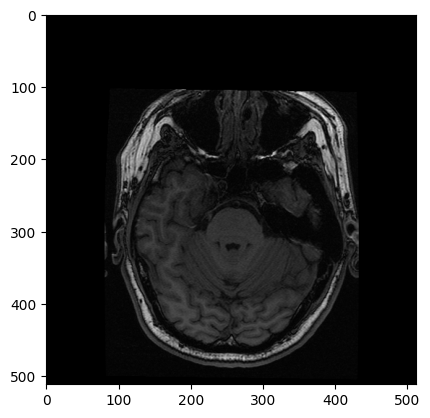

In [16]:
plt.imshow(dataset.pixel_array, cmap=plt.cm.gray);

# Exercise 2

Download FLAIR scan from this subject, plot any slice present in the dataset and print out its summary. Try to see what is different between these two scans (Hint: look at the [description](https://en.wikipedia.org/wiki/Fluid-attenuated_inversion_recovery) of the FLAIR technique).

 34.1 MiB |                                              #        |   6.8 MiB/s


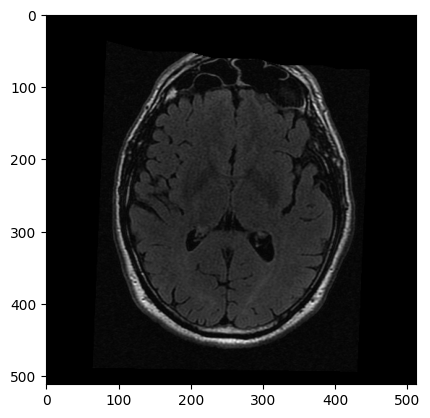

In [17]:
# Solution
mri_session.scans['FLAIR'].download(os.path.join("..", "data", "FLAIR.zip"))
with zipfile.ZipFile(os.path.join("..", "data", "FLAIR.zip"), "r") as zip_ref:
        zip_ref.extractall(os.path.join("..", "data"))
dataset = pydicom.dcmread(os.path.join("..", "data","ANONYMIZ/scans/5-FLAIR/resources/DICOM/files/1.3.6.1.4.1.40744.99.141253643552231291697372180164147575979-5-32-1qws4aj.dcm"))
dataset
dataset.InversionTime
plt.imshow(dataset.pixel_array, cmap=plt.cm.gray)
plt.show()

## Applying image preprocessing

Now, we are going to apply Gaussian filter to the selected image slice. It is typically used in image processing pipelines to reduce noise and enhance details on an image at the various scales. It is also commonly used before applying edge detection methods, since they are sensitive to noise in an image. For more information about the filter you can have a look at its Wikipedia [page](https://en.wikipedia.org/wiki/Gaussian_blur). We will be using `filters.gaussian` implementation of this algorithm from scikit-image library.

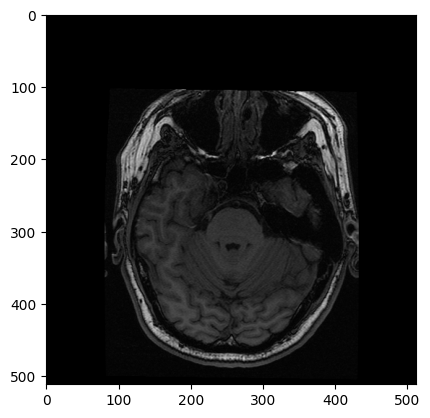

In [18]:
# Reload the original image from the file
dataset = pydicom.dcmread(os.path.join("..", "data", "ANONYMIZ/scans/6-T1/resources/DICOM/files/1.3.6.1.4.1.40744.99.141253643552231291697372180164147575979-6-43-5opby1.dcm"))
original_image = dataset.pixel_array
# Plot the slice
plt.imshow(original_image, cmap=plt.cm.gray);

Now, let's try to apply an edge detection algorithm to the image. We will use edge detection algorithm based on [Sobel filter](https://en.wikipedia.org/wiki/Sobel_operator).

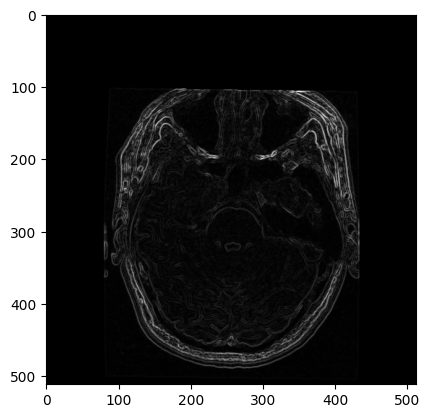

In [19]:
edges_original = filters.sobel(original_image)
plt.imshow(edges_original, cmap=plt.cm.gray);

As you can see, the algorithm detects quite a lot of edges throughout the whole image. Now we will apply Gaussian smoothing first and see how it affects the edge detection algorithm output.

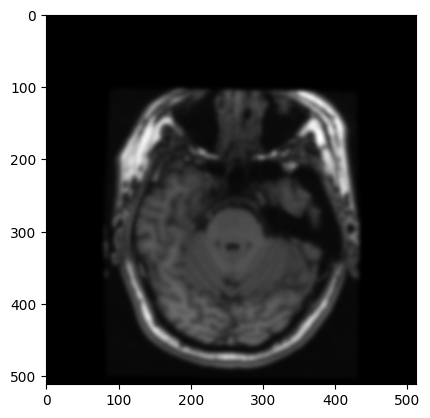

In [20]:
filtered_image = filters.gaussian(original_image, sigma=3.0)
plt.imshow(filtered_image, cmap=plt.cm.gray);

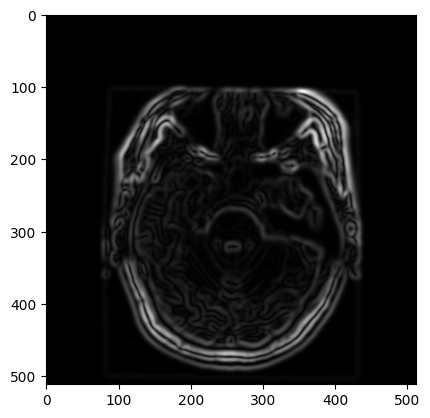

In [21]:
edges_filtered = filters.sobel(filtered_image)
plt.imshow(edges_filtered, cmap=plt.cm.gray);

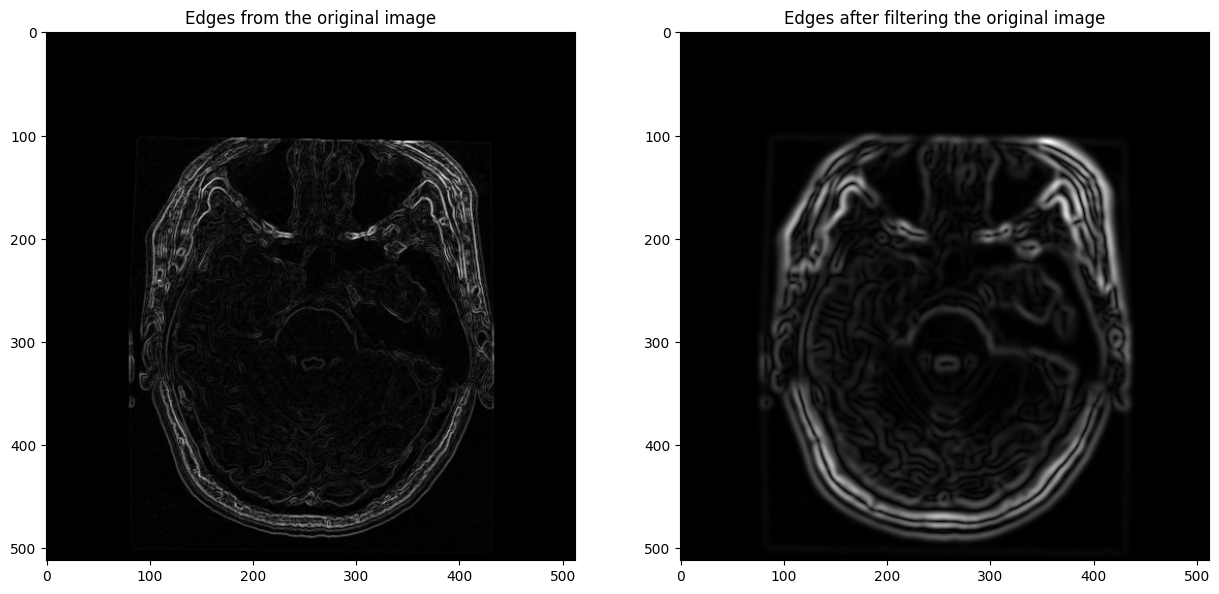

In [22]:
f, axes = plt.subplots(1,2, figsize=(15, 15))
axes[0].imshow(edges_original, cmap=plt.cm.gray)
axes[0].title.set_text("Edges from the original image")
axes[1].imshow(edges_filtered, cmap=plt.cm.gray)
axes[1].title.set_text("Edges after filtering the original image")

As you can see, after applying Gaussian smoothing, during the edge detection the algorithm focuses on higher-level features of the image. **Exercise 3**: Try changing values of Sigma parameter to see how it affects the outcome of edge detection algorithm.

In [25]:
# Close the session
session.disconnect()

## (Optional) Importing data into XNAT

It is also possible to add data to the server using XNAT REST API. `xnatpy` wraps it in the `import_` method. You can use it in the following way:

In [ ]:
# session.services.import_('/path/to/archive.zip', project='project_name', subject='subject_name')

Uploading directly to the archive is often undesirable, as you might want to inspect data before finalizing archival. XNAT has a specific intermediate storage - prearchive - giving a user a chance to review the incoming data. You can upload data to prearchive by specifying it as destination:

In [ ]:
# session.services.import_('/path/to/archive.zip', project='project_name', subject='subject_name',  destination='/prearchive')

**NB**: run these cells only after connecting to your local XNAT installation and change the values to something that makes sense (correct paths, project and subject names, etc.)